In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from activ.analytics import heatmap
from activ.clustering import UmapClusteringResults
from os.path import dirname, join
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

In [19]:
f = h5py.File('/Users/ahyeon/Desktop/activ misc/predict_scores2.h5', 'r')

In [20]:
predictions = f['score'][:]
norm_predictions = f['norm_score'][:]
labels = f['clusters'][:]
umap_dims = f['umap_dimensions'][:]
cluster_sizes = f['cluster_sizes'][:]

In [21]:
def conf_alliter(size, predicted, actual):
    confalliter = []
    for j in range(50):
        conf = np.zeros((size,size))
        labs = list(map(int, actual[j][size-2]))
        preds = list(map(int, predicted[j][size-2]))
        for l, p in zip(labs, preds):
            conf[l,p] += 1
        confalliter.append(conf)
    return confalliter

In [22]:
def accuracy(mat):
    return mat.trace()/mat.sum()

def specificity(tn, fp):
    return tn/(tn+fp)

def sensitivity(tp, fn):
    return tp/(tp+fn)

def fscore(tp, fp, fn):
    return (2*tp)/(2*tp+fp+fn)

In [23]:
def ind_statistics(matrix):
    mat = np.matrix(matrix)
    allvals=[]
    tps = []
    tns = []
    fps = []
    fns = []
    for i in range(mat.shape[0]):
        tp = mat[i,i]
        tn = mat.sum() - mat[i,:].sum() - mat[:,i].sum() + mat[i,i]
        fp = mat[:,i].sum() - mat[i,i]
        fn = mat[i,:].sum() - mat[i,i]
        tps.append(tp)
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
    allvals.append(tps)
    allvals.append(tns)
    allvals.append(fps)
    allvals.append(fns)
    return allvals

In [24]:
def find_var_sens(array):
    allsens = []
    for i in range(len(array[0])):
        vals = []
        for elem in array:
            vals.append(elem[i])
        tp = vals[0]
        tn = vals[1]
        fp = vals[2]
        fn = vals[3]

        sens = sensitivity(tn, fp)
        allsens.append(sens)
    allsens_var = np.var(allsens)
    return(allsens_var)

In [25]:
def find_var_fscore(array):
    allf = []
    for i in range(len(array[0])):
        vals = []
        for elem in array:
            vals.append(elem[i])
        tp = vals[0]
        tn = vals[1]
        fp = vals[2]
        fn = vals[3]

        f = fscore(tp, fp, fn)
        allf.append(f)
    allf_var = np.var(allf)
    return(allf_var)

In [26]:
var_f_arr = np.zeros((len(cluster_sizes), 50))
for ii, c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    f_50 = []
    norm_f_50 = []
    for i in range(50):
        x = ind_statistics(all50mat[i])
        y = ind_statistics(norm_all50mat[i])
        f = find_var_fscore(x)
        norm_f = find_var_fscore(y)
        f_50.append(f)
        norm_f_50.append(norm_f)
    foc = [j/k for j,k in zip(f_50, norm_f_50)]
    var_f_arr[ii,:] = foc

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


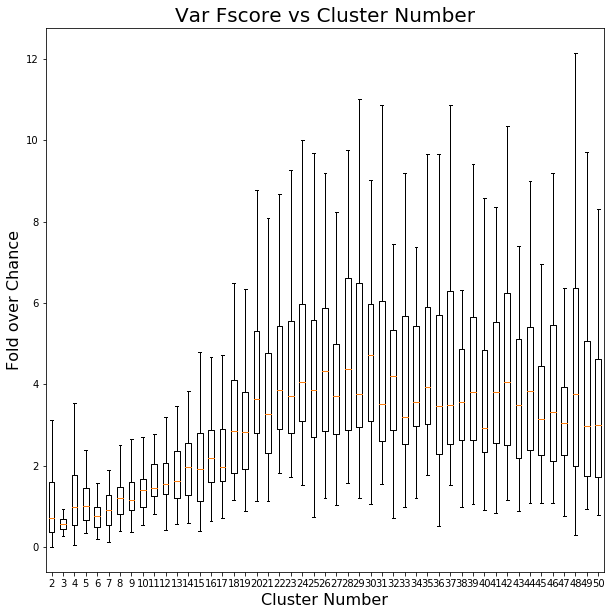

In [27]:
plt.figure(figsize=(10,10))
plt.boxplot(var_f_arr.T, labels = cluster_sizes, showfliers=False)
plt.xlabel('Cluster Number', fontsize=16)
plt.ylabel('Fold over Chance', fontsize=16)
plt.title('Var Fscore vs Cluster Number', fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/var_fscore_vs_clusters_predictions.pdf')

In [28]:
var_sens_arr = np.zeros((len(cluster_sizes), 50))
for ii, c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    sens_50 = []
    norm_sens_50 = []
    for i in range(50):
        x = ind_statistics(all50mat[i])
        y = ind_statistics(norm_all50mat[i])
        sens = find_var_sens(x)
        norm_sens = find_var_sens(y)
        sens_50.append(sens)
        norm_sens_50.append(norm_sens)
    foc = [j/k for j,k in zip(sens_50, norm_sens_50)]
    var_sens_arr[ii,:] = foc

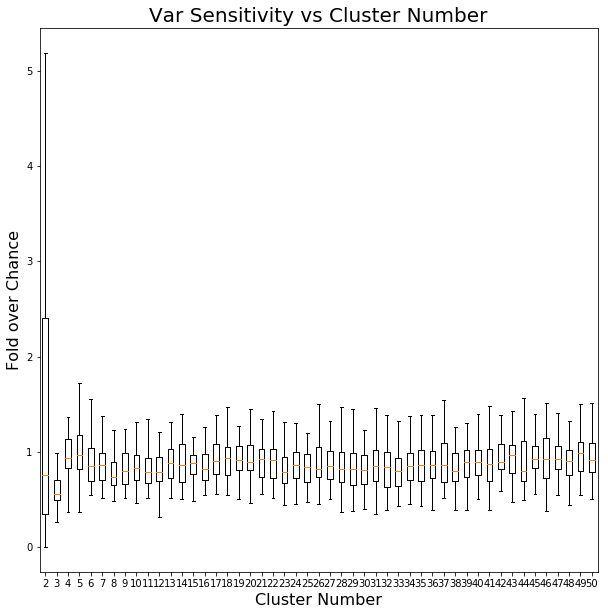

In [29]:
plt.figure(figsize=(10,10))
plt.boxplot(var_sens_arr.T, labels = cluster_sizes, showfliers=False)
plt.xlabel('Cluster Number', fontsize=16)
plt.ylabel('Fold over Chance', fontsize=16)
plt.title('Var Sensitivity vs Cluster Number', fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/var_sens_vs_clusters_predictions.pdf')